In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.pytorch
import cv2
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from cutmix.cutmix import CutMix
# from cutmix.utils import CutMixCrossEntropyLoss
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm

import wandb

config={
    "lr": 3e-4,
    "dropout": 0.5,
    "architecture": "efficientnet-b7",
    "dataset": "mask",
    "augmentation" : "cutmix",
    "loss" : "weighted",
    "gamma" : 0.9,
    "batch_size" : 50,
    "epochs" : 20,
}
config['model'] = '_'.join([config['architecture'], config['dataset'], config['augmentation'], config['loss'], str(config['batch_size']), str(config['lr']), str(config['gamma'])])
wandb.init(project="MaskClassification", name=config['model'], config=config)



wandb: Currently logged in as: youkind (use `wandb login --relogin` to force relogin)

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



In [2]:
print('CUDA GPU available : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
device = torch.device("cuda")
CUDA_LAUNCH_BLOCKING=1

CUDA GPU available : True
1 GPU(s) is(are) allocated


In [3]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'
train_dir = '/opt/ml/input/data/train'

labels_to_class = {}
it = [(m, g, a) for m in [0,1,2] for g in [0, 1] for a in [0, 1, 2]]
for i, (m, g, a) in enumerate(it):
    labels_to_class[(m, g, a)] = i

## Dataset

In [4]:
class TrainDataset(Dataset):
    def __init__(self, train_dir, is_Train=True, transform=None):
        super().__init__()
        
        csv_path = os.path.join(train_dir, 'train.csv')
        csv = pd.read_csv(csv_path)
        self.image_dir = os.path.join(train_dir, 'images')
        self.transform = transform
        self.image_path = []
        path = csv['path']
        
        for p in path:
            images = [os.path.join(*[self.image_dir, p, image]) for image in os.listdir(os.path.join(self.image_dir, p)) if not image[:1] == '.']
            for image in images:
                self.image_path.append(image)
                
        self.comb_dic = {}
        comb = [(m, g, a) for m in ['m', 'i', 'n'] for g in ['male', 'female'] for a in [0, 1, 2]]
        for i, (m, g, a) in enumerate(comb):
            self.comb_dic[(m, g, a)] = i
            
    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_name = self.image_path[idx]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        features = image_name.split('/')[-2:]
        
        mask = features[1][0]
        age = int(features[0].split('_')[-1])
        gender = features[0].split('_')[1]
        
        if age >= 58: # 원래 60
            age = 2
        elif age >= 30: # 원래 30
            age = 1
        else:
            age = 0        
        
        target = self.comb_dic[(mask, gender, age)]
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        return image, target

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.img_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
from copy import copy
# from torch.utils.data.dataset import random_split

tfms = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.1, p=0.6),
        A.GaussNoise(p=0.5),
        A.transforms.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
tfms_test = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.transforms.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
val_idx = []
person_idx = list(range(2700))

np.random.seed(211)
np.random.shuffle(person_idx)

n_val_person = int(2700 * 0.2)
val_person_idx = person_idx[:n_val_person]
train_indices = []
val_indices = []
for i in range(2700*15):
    if i // 15 not in val_person_idx:
        train_indices.append(i)
    else:
        val_indices.append(i)

# print(train_indices)
# print(val_indices)
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

dataset = TrainDataset(train_dir, transform=tfms)
val_dataset = copy(dataset)
train_dataset = CutMix(dataset, num_class=18, beta=1.0, prob=0.5, num_mix=2)
# print(len(dataset))
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers=4, pin_memory=True, sampler=train_indices)
val_loader = DataLoader(val_dataset, num_workers=4, batch_size=config['batch_size'], pin_memory=True, sampler=val_indices)

In [6]:
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))
# dataset[0]

## Model

In [7]:
from efficientnet_pytorch import EfficientNet
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.backbone = EfficientNet.from_pretrained(config['architecture'], num_classes=18)
        self.best_f1 = 0
        self.best_valid = 999999999
    def forward(self, x):
        return self.backbone(x)
        
model = Net().to(device)

Loaded pretrained weights for efficientnet-b7


In [8]:
import torch.optim as optim 

class_distribution = torch.tensor([2745, 2050, 415, 3660, 4085, 545, 
                      555*5, 314*5, 179*5, 726*5, 669*5, 257*5, 
                      555*5, 314*5, 179*5, 726*5, 669*5, 257*5])
normedWeights = [1 - (x / sum(class_distribution)) for x in class_distribution]
loss_distribution = class_distribution / class_distribution.sum()
# print(class_distribution)
loss_distribution = 1.0 / loss_distribution
loss_distribution = (loss_distribution / loss_distribution.sum()*10).to(device)
print(loss_distribution)

class CutMixCrossEntropyLoss(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = weight

    def forward(self, inputs, targets):
        if len(targets.size()) == 1:
            targets = torch.nn.functional.one_hot(targets, num_classes=input.size(-1))
            targets = targets.float().cuda()
        logsoftmax = torch.nn.LogSoftmax(dim=1)

        return torch.mean(torch.sum(-targets * logsoftmax(inputs) * self.weight, dim=1))

# origin_criterion = CutMixCrossEntropyLoss(True)
val_criterion = nn.CrossEntropyLoss(weight=loss_distribution)
cutmix_criterion = CutMixCrossEntropyLoss(weight=loss_distribution)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['gamma'], verbose=True)

tensor([0.2903, 0.3887, 1.9202, 0.2177, 0.1951, 1.4621, 0.2872, 0.5076, 0.8904,
        0.2195, 0.2382, 0.6201, 0.2872, 0.5076, 0.8904, 0.2195, 0.2382, 0.6201],
       device='cuda:0')
Adjusting learning rate of group 0 to 3.0000e-04.


In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def check():
    model.eval()
    val_loss = 0.0
    counter = 0
    y_true = []
    y_predicted = []
    
    with torch.no_grad():
        prog_bar = tqdm(enumerate(val_loader), total=int(len(val_indices)/val_loader.batch_size))
        for i, (x, y) in prog_bar:
            counter += 1
            y_true += y.tolist()
            
            x = x.to(device=device)
            y = y.to(device=device)
    
            scores = model(x)
            _, predictions = scores.max(1)
            y_predicted += predictions.tolist()
            
            
            loss = val_criterion(scores, y)
            
            val_loss += loss.item()
#     print(y_true, y_predicted)
    cm = confusion_matrix(y_true, y_predicted)
    F1 = []
    for c in range(18):
        precision = cm[c][c] / np.sum(cm, axis=0)[c]
        recall = cm[c][c] / np.sum(cm, axis=1)[c]
        F1.append(2 * precision * recall / (precision + recall))
    macro_F1 = np.mean(F1)
    
    print("< VALIDATION >")
    print("*"*73)
    print("Validation Loss :", val_loss/counter)
    print("-"*73)
    print("Total Accuracy")
    print(accuracy_score(y_true, y_predicted) * 100, "%")
    print("-"*73)
    print("Confusion Matrix")
    for row in cm:
        for c in row:
            print(str(c).ljust(4), end='')
        print()
    print("-"*73)
    print("Validation F1 score :" , macro_F1)
    for c, f in enumerate(F1):
        print("Class", c, ":", f)
        
    if model.best_f1 < macro_F1:
        model.best_f1 = macro_F1
#     if model.best_valid > val_loss/counter:
#         model.best_valid = val_loss/counter
        torch.save(model.state_dict(), '/opt/ml/weights/{}/{:.4f}.pt'.format(config['model'], model.best_f1))
    print("model saved!")
    print("*"*73)
    print()
    wandb.log({
        "Validation Loss" : val_loss/counter, 
        "Validation Total Accuracy" :accuracy_score(y_true, y_predicted) * 100, 
        "Validation F1" : macro_F1,
    })
        
    model.train()

In [10]:

folder = '/opt/ml/weights/{}'.format(config['model'])
if not os.path.exists(folder):
    os.mkdir(folder)

for epoch in range(config['epochs']):
    print("Epoch :", epoch + 1)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    total_it = int(len(train_indices)/train_loader.batch_size)
    prog_bar = tqdm(enumerate(train_loader), total=total_it)
    for i, (inputs, labels) in prog_bar:
        
        counter += 1
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        total += labels.size(0)
    
        outputs = model(inputs)
        loss = cutmix_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs.data, 1)
#         train_running_correct += (preds == labels).sum().item()
        
        train_running_loss += loss.item()
        
        if i == total_it//2 or i == total_it-1:
            train_loss = train_running_loss / counter
#             train_accuracy = 100. * train_running_correct / total
            
            print("Train Loss :", train_loss)
#             print("Train Accuracy :", train_accuracy)
            wandb.log({"Train Loss" : train_loss})
            check()
    scheduler.step()
    train_running_loss = 0.0
    train_running_correct = 0
print("Finish")

Epoch : 1


 50%|█████     | 324/648 [04:28<04:26,  1.22it/s]

Train Loss : 0.6535819014219137



100%|██████████| 162/162 [00:32<00:00,  4.92it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.6895261489682727
-------------------------------------------------------------------------
Total Accuracy
75.44444444444444 %
-------------------------------------------------------------------------
Confusion Matrix
447 30  0   1   4   1   1   0   0   0   0   0   1   0   0   0   0   0   
22  230 40  2   15  6   0   0   0   0   0   0   0   0   0   0   0   0   
0   59  124 0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   
12  6   0   735 17  1   0   0   0   9   0   0   0   0   0   0   0   0   
1   15  0   58  337 277 0   0   0   0   2   0   0   0   0   0   0   0   
0   0   0   1   21  223 0   0   0   0   0   0   0   0   0   0   0   0   
13  4   0   0   0   0   411 21  0   33  2   0   1   0   0   0   0   0   
0   21  3   0   0   0   16  190 45  13  27  0   0   0   0   0   0   0   
0   0   12  0   0   0   0   56  117 0   0   0   0   0   0   0   0   0   
0   3   0   0   0

 50%|█████     | 325/648 [05:02<59:02, 10.97s/it]

model saved!
*************************************************************************



100%|█████████▉| 647/648 [09:27<00:00,  1.23it/s]

Train Loss : 0.5862451181919487



100%|██████████| 162/162 [00:33<00:00,  4.91it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.5720793453999508
-------------------------------------------------------------------------
Total Accuracy
79.91358024691358 %
-------------------------------------------------------------------------
Confusion Matrix
463 9   1   3   8   0   1   0   0   0   0   0   0   0   0   0   0   0   
35  147 81  1   18  33  0   0   0   0   0   0   0   0   0   0   0   0   
0   36  140 0   0   9   0   0   0   0   0   0   0   0   0   0   0   0   
3   1   0   723 50  1   0   0   0   2   0   0   0   0   0   0   0   0   
1   0   0   15  316 355 0   0   0   0   3   0   0   0   0   0   0   0   
0   0   0   0   13  232 0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   457 26  0   0   0   0   0   0   0   0   0   0   
0   5   1   0   0   0   29  220 45  0   11  2   0   2   0   0   0   0   
0   0   0   0   0   0   0   72  111 0   1   1   0   0   0   0   0   0   
1   0   0   2   0

100%|██████████| 648/648 [10:01<00:00,  1.08it/s]

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 2.7000e-04.
Epoch : 2



 50%|█████     | 324/648 [04:26<04:24,  1.22it/s]

Train Loss : 0.4311318824841426



100%|██████████| 162/162 [00:32<00:00,  4.95it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.6373274625267511
-------------------------------------------------------------------------
Total Accuracy
83.79012345679013 %
-------------------------------------------------------------------------
Confusion Matrix
480 1   0   0   1   0   3   0   0   0   0   0   0   0   0   0   0   0   
46  236 26  0   7   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   53  131 0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
20  1   0   731 24  0   0   0   0   4   0   0   0   0   0   0   0   0   
15  5   0   36  517 116 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   1   0   67  177 0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   468 15  0   0   0   0   0   0   0   0   0   0   
0   6   0   0   0   0   30  238 30  0   11  0   0   0   0   0   0   0   
0   0   1   0   0   0   0   75  104 0   4   0   0   0   1   0   0   0   
0   0   0   0   0

 50%|█████     | 325/648 [05:01<58:37, 10.89s/it]

model saved!
*************************************************************************



100%|█████████▉| 647/648 [09:25<00:00,  1.23it/s]

Train Loss : 0.42026654939040725



100%|██████████| 162/162 [00:32<00:00,  4.94it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.5820040665107009
-------------------------------------------------------------------------
Total Accuracy
84.30864197530865 %
-------------------------------------------------------------------------
Confusion Matrix
466 10  0   0   6   0   3   0   0   0   0   0   0   0   0   0   0   0   
19  241 38  0   12  1   1   1   1   0   1   0   0   0   0   0   0   0   
0   40  144 0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   
29  5   0   652 85  2   0   0   0   7   0   0   0   0   0   0   0   0   
1   10  0   4   490 181 0   0   0   0   3   1   0   0   0   0   0   0   
0   0   0   0   32  212 0   0   0   0   0   1   0   0   0   0   0   0   
1   0   0   0   0   0   484 0   0   0   0   0   0   0   0   0   0   0   
0   6   0   0   0   0   30  258 12  0   9   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   83  98  0   0   4   0   0   0   0   0   0   
2   0   0   0   0

100%|██████████| 648/648 [10:00<00:00,  1.08it/s]

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 2.4300e-04.
Epoch : 3



 50%|█████     | 324/648 [04:27<04:25,  1.22it/s]

Train Loss : 0.36821721205344565



100%|██████████| 162/162 [00:32<00:00,  4.93it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.5064121570300173
-------------------------------------------------------------------------
Total Accuracy
87.35802469135803 %
-------------------------------------------------------------------------
Confusion Matrix
472 9   0   0   3   0   1   0   0   0   0   0   0   0   0   0   0   0   
25  246 37  0   5   2   0   0   0   0   0   0   0   0   0   0   0   0   
0   31  154 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
14  2   0   744 17  0   0   0   0   3   0   0   0   0   0   0   0   0   
4   1   1   27  521 135 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   1   0   36  208 0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   480 3   0   0   0   0   0   0   0   0   0   0   
0   6   0   0   0   0   23  249 29  0   8   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   37  147 0   1   0   0   0   0   0   0   0   
0   1   0   0   0

 50%|█████     | 325/648 [05:01<58:53, 10.94s/it]

model saved!
*************************************************************************



100%|█████████▉| 647/648 [09:26<00:00,  1.23it/s]

Train Loss : 0.3654102921761848



100%|██████████| 162/162 [00:32<00:00,  4.94it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.4389056212924145
-------------------------------------------------------------------------
Total Accuracy
89.5432098765432 %
-------------------------------------------------------------------------
Confusion Matrix
481 3   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
21  259 24  0   10  1   0   0   0   0   0   0   0   0   0   0   0   0   
0   21  164 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
20  0   0   704 55  0   0   0   0   1   0   0   0   0   0   0   0   0   
5   10  0   12  541 121 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   27  218 0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   481 1   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   22  257 18  1   10  2   0   0   0   0   0   0   
0   0   0   0   0   0   0   31  154 0   0   0   0   0   0   0   0   0   
0   0   0   9   0 

100%|██████████| 648/648 [10:00<00:00,  1.08it/s]

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 2.1870e-04.
Epoch : 4



 50%|█████     | 324/648 [04:27<04:26,  1.22it/s]

Train Loss : 0.33250769087901483



100%|██████████| 162/162 [00:33<00:00,  4.91it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.39018907489967936
-------------------------------------------------------------------------
Total Accuracy
89.87654320987654 %
-------------------------------------------------------------------------
Confusion Matrix
481 0   0   1   1   0   2   0   0   0   0   0   0   0   0   0   0   0   
32  243 35  0   4   1   0   0   0   0   0   0   0   0   0   0   0   0   
0   20  165 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
14  1   0   728 35  1   0   0   0   1   0   0   0   0   0   0   0   0   
7   5   1   13  522 141 0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   9   236 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   485 0   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   24  263 19  1   3   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   30  155 0   0   0   0   0   0   0   0   0   
0   0   0   1   

 50%|█████     | 325/648 [05:02<59:08, 10.99s/it]

model saved!
*************************************************************************



100%|█████████▉| 647/648 [09:26<00:00,  1.23it/s]

Train Loss : 0.33751549006060316



100%|██████████| 162/162 [00:32<00:00,  4.92it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.39212327839139804
-------------------------------------------------------------------------
Total Accuracy
90.19753086419753 %
-------------------------------------------------------------------------
Confusion Matrix
461 15  2   0   5   0   2   0   0   0   0   0   0   0   0   0   0   0   
24  264 23  0   1   2   0   1   0   0   0   0   0   0   0   0   0   0   
0   12  173 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
14  0   0   726 38  0   0   0   0   2   0   0   0   0   0   0   0   0   
4   9   0   6   578 92  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   27  218 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   479 6   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   24  263 22  0   1   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   19  166 0   0   0   0   0   0   0   0   0   
0   0   0   2   

100%|██████████| 648/648 [10:01<00:00,  1.08it/s]

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.9683e-04.
Epoch : 5



 50%|█████     | 324/648 [04:27<04:26,  1.22it/s]

Train Loss : 0.3097859047009395



100%|██████████| 162/162 [00:32<00:00,  4.92it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.377034939515094
-------------------------------------------------------------------------
Total Accuracy
92.56790123456791 %
-------------------------------------------------------------------------
Confusion Matrix
483 2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
27  271 17  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   16  169 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
18  0   1   754 3   0   0   0   0   4   0   0   0   0   0   0   0   0   
10  18  0   26  605 30  0   0   0   0   1   0   0   0   0   0   0   0   
0   1   0   0   35  209 0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   480 3   0   0   0   0   1   0   0   0   0   0   
0   5   0   0   0   0   23  266 20  0   1   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   18  167 0   0   0   0   0   0   0   0   0   
0   0   0   1   0 

 50%|█████     | 325/648 [05:02<58:58, 10.96s/it]

model saved!
*************************************************************************



100%|█████████▉| 647/648 [09:26<00:00,  1.22it/s]

Train Loss : 0.3155550264098026



100%|██████████| 162/162 [00:32<00:00,  4.95it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.33157384891154956
-------------------------------------------------------------------------
Total Accuracy
93.27160493827161 %
-------------------------------------------------------------------------
Confusion Matrix
485 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
38  253 18  0   5   1   0   0   0   0   0   0   0   0   0   0   0   0   
0   12  173 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
10  0   0   769 0   0   0   0   0   1   0   0   0   0   0   0   0   0   
12  1   1   30  597 48  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   23  222 0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   482 0   0   0   0   0   1   0   0   0   0   0   
0   6   0   0   0   0   30  267 8   0   4   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   14  171 0   0   0   0   0   0   0   0   0   
0   0   0   3   

100%|██████████| 648/648 [10:01<00:00,  1.08it/s]

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.7715e-04.
Epoch : 6



 50%|█████     | 324/648 [04:27<04:25,  1.22it/s]

Train Loss : 0.28997902993972485



100%|██████████| 162/162 [00:32<00:00,  4.96it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.2664867240395167
-------------------------------------------------------------------------
Total Accuracy
94.85185185185185 %
-------------------------------------------------------------------------
Confusion Matrix
481 0   0   0   0   0   3   0   0   0   0   0   1   0   0   0   0   0   
24  283 6   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   19  166 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
6   0   0   763 9   0   0   0   0   2   0   0   0   0   0   0   0   0   
7   3   0   18  632 24  0   0   0   0   6   0   0   0   0   0   0   0   
0   0   0   0   27  218 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   485 0   0   0   0   0   0   0   0   0   0   0   
0   4   0   0   0   0   23  260 28  0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   185 0   0   0   0   0   0   0   0   0   
0   0   0   0   0

 50%|█████     | 325/648 [05:02<58:32, 10.88s/it]

model saved!
*************************************************************************



100%|█████████▉| 647/648 [09:26<00:00,  1.22it/s]

Train Loss : 0.2954000173205579



100%|██████████| 648/648 [10:00<00:00,  1.08it/s]

< VALIDATION >
*************************************************************************
Validation Loss : 0.1835966251595061
-------------------------------------------------------------------------
Total Accuracy
94.96296296296296 %
-------------------------------------------------------------------------
Confusion Matrix
480 5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
12  291 9   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   
0   12  173 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   772 7   0   0   0   0   1   0   0   0   0   0   0   0   0   
1   7   0   8   582 91  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   3   242 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   482 3   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   5   298 5   0   2   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   29  156 0   0   0   0   0   0   0   0   0   
0   0   0   3   0


 50%|█████     | 324/648 [04:26<04:29,  1.20it/s]

Train Loss : 0.2804622843173834



100%|██████████| 162/162 [00:32<00:00,  4.92it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.17005190656830868
-------------------------------------------------------------------------
Total Accuracy
96.25925925925925 %
-------------------------------------------------------------------------
Confusion Matrix
481 4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
18  287 4   0   6   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   9   176 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   0   0   764 10  0   0   0   0   1   0   0   0   0   0   0   0   0   
2   4   0   12  641 30  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   2   243 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   485 0   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   20  277 7   0   6   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   4   181 0   0   0   0   0   0   0   0   0   
0   0   0   2   

 50%|█████     | 325/648 [05:01<58:58, 10.95s/it]

model saved!
*************************************************************************



100%|█████████▉| 647/648 [09:26<00:00,  1.23it/s]

Train Loss : 0.2885490556557973



100%|██████████| 648/648 [09:59<00:00,  1.08it/s]

< VALIDATION >
*************************************************************************
Validation Loss : 0.1585256022769084
-------------------------------------------------------------------------
Total Accuracy
96.04938271604938 %
-------------------------------------------------------------------------
Confusion Matrix
481 1   0   1   1   0   1   0   0   0   0   0   0   0   0   0   0   0   
18  284 11  0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   
0   3   182 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   774 5   0   0   0   0   1   0   0   0   0   0   0   0   0   
2   3   0   21  627 36  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   12  233 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   485 0   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   5   297 6   0   2   0   0   0   0   0   0   0   
0   0   2   0   0   0   0   6   177 0   0   0   0   0   0   0   0   0   
0   0   0   7   0


 50%|█████     | 324/648 [04:27<04:25,  1.22it/s]

Train Loss : 0.27449897137972024



 50%|█████     | 325/648 [05:01<58:00, 10.78s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 0.1738395132239402
-------------------------------------------------------------------------
Total Accuracy
95.96296296296296 %
-------------------------------------------------------------------------
Confusion Matrix
484 0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
32  254 25  0   3   1   0   0   0   0   0   0   0   0   0   0   0   0   
0   2   183 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   760 19  0   0   0   0   1   0   0   0   0   0   0   0   0   
1   2   0   3   660 23  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   18  227 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   485 0   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   11  291 7   0   1   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   6   179 0   0   0   0   0   0   0   0   0   
0   0   0   2   0

100%|█████████▉| 647/648 [09:24<00:00,  1.22it/s]

Train Loss : 0.2804800095151604



100%|██████████| 162/162 [00:32<00:00,  4.97it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.12441806167933261
-------------------------------------------------------------------------
Total Accuracy
96.22222222222221 %
-------------------------------------------------------------------------
Confusion Matrix
481 3   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
20  275 17  0   1   2   0   0   0   0   0   0   0   0   0   0   0   0   
0   1   184 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   761 13  2   0   0   0   0   0   0   0   0   0   0   0   0   
3   2   0   4   627 53  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   1   244 0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   484 0   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   8   293 6   0   2   1   0   0   0   0   0   0   
0   0   0   0   0   0   0   7   178 0   0   0   0   0   0   0   0   0   
0   0   0   5   

100%|██████████| 648/648 [10:00<00:00,  1.08it/s]

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.2914e-04.
Epoch : 9



 50%|█████     | 324/648 [04:27<04:26,  1.22it/s]

Train Loss : 0.2629886173743468



100%|██████████| 162/162 [00:32<00:00,  4.94it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.10446703503264781
-------------------------------------------------------------------------
Total Accuracy
97.25925925925925 %
-------------------------------------------------------------------------
Confusion Matrix
482 1   0   0   1   0   1   0   0   0   0   0   0   0   0   0   0   0   
20  288 7   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   8   177 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
5   0   0   769 5   0   0   0   0   1   0   0   0   0   0   0   0   0   
1   3   0   8   641 35  0   0   0   0   2   0   0   0   0   0   0   0   
0   0   0   0   1   244 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   485 0   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   12  290 7   0   1   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   185 0   0   0   0   0   0   0   0   0   
0   0   0   3   

 50%|█████     | 325/648 [05:01<58:42, 10.90s/it]

model saved!
*************************************************************************



100%|█████████▉| 647/648 [09:25<00:00,  1.23it/s]

Train Loss : 0.2702115208232476



100%|██████████| 162/162 [00:32<00:00,  4.94it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.0962455480526213
-------------------------------------------------------------------------
Total Accuracy
97.07407407407408 %
-------------------------------------------------------------------------
Confusion Matrix
479 4   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   
9   299 7   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   1   184 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
8   0   0   705 67  0   0   0   0   0   0   0   0   0   0   0   0   0   
1   4   0   1   669 14  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   11  234 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   485 0   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   8   301 1   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   2   183 0   0   0   0   0   0   0   0   0   
0   0   0   3   0

100%|██████████| 648/648 [09:59<00:00,  1.08it/s]

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.1623e-04.
Epoch : 10



 50%|█████     | 324/648 [04:27<04:25,  1.22it/s]

Train Loss : 0.2602149721750846



100%|██████████| 162/162 [00:32<00:00,  4.93it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.06026601669361332
-------------------------------------------------------------------------
Total Accuracy
97.98765432098764 %
-------------------------------------------------------------------------
Confusion Matrix
484 0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
12  292 10  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   0   185 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   760 16  0   0   0   0   1   0   0   0   0   0   0   0   0   
0   3   0   0   665 21  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   0   245 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   485 0   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   6   297 7   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   185 0   0   0   0   0   0   0   0   0   
0   0   0   4   

 50%|█████     | 325/648 [05:01<58:44, 10.91s/it]

model saved!
*************************************************************************



100%|█████████▉| 647/648 [09:25<00:00,  1.23it/s]

Train Loss : 0.2636616979898126



100%|██████████| 162/162 [00:32<00:00,  4.97it/s]


< VALIDATION >
*************************************************************************
Validation Loss : 0.0736328699413319
-------------------------------------------------------------------------
Total Accuracy
98.18518518518519 %
-------------------------------------------------------------------------
Confusion Matrix
485 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
17  295 3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   5   180 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   771 8   0   0   0   0   0   0   0   0   0   0   0   0   0   
0   3   0   1   667 18  0   0   0   0   1   0   0   0   0   0   0   0   
0   0   0   0   3   242 0   0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   485 0   0   0   0   0   0   0   0   0   0   0   
0   5   0   0   0   0   9   300 1   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   7   178 0   0   0   0   0   0   0   0   0   
0   0   0   4   0

100%|██████████| 648/648 [09:59<00:00,  1.08it/s]

model saved!
*************************************************************************

Adjusting learning rate of group 0 to 1.0460e-04.
Epoch : 11



  0%|          | 3/648 [00:03<14:11,  1.32s/it]


KeyboardInterrupt: 

## Testing

In [12]:
model.load_state_dict(torch.load('/opt/ml/weights/{}/{:.4f}.pt'.format(config['model'], model.best_f1))), model.best_f1
# model.load_state_dict(torch.load('/opt/ml/weights/{}/0.8712.pt'.format(config['model'])))

(<All keys matched successfully>, 0.9786319017261503)

In [19]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, tfms)

loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=64,
    num_workers=4
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# device = torch.device('cuda')

model.eval()
device = torch.device("cuda:0")
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []

prog_bar = tqdm(enumerate(loader), total=int(len(dataset)/loader.batch_size))
for i, images in prog_bar:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

197it [00:50,  3.90it/s]                         

test inference is done!


tensor([[-0.9847, -1.3921, -0.8136,  0.4215, -0.8168, -0.9841, -1.5729, -1.6728,
         -1.3320, -1.2148, -1.7658, -2.2571, -0.9393,  4.6905,  6.9479, -0.2184,
         -0.6867, -1.4754]], device='cuda:0', grad_fn=<AddmmBackward>)
Normal
Male
60 ~


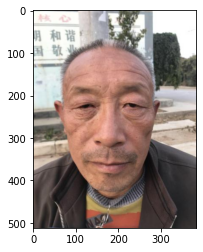

In [20]:

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

image = tfms_test(image=image)['image'].to(device)
image = image.unsqueeze(0)
pred = model(image)
print(pred)
label = np.argmax(pred.detach().cpu().numpy())
#
masklabel = {0: "Mask", 1: "Incorrect", 2: "Normal"}
genderlabel = {0: "Male", 1: "Female"}
agelabel = {0: "~ 30", 1: "30 ~ 60", 2: "60 ~"}

feature_to_label = {}
features = [(m, g, a) for m in ['Mask', 'Incorrect', 'Normal'] for g in ['Male', 'Female'] for a in ["~ 30", "30 ~ 60", "60 ~"]]
for i, (m, g, a) in enumerate(features):
    feature_to_label[(m, g, a)] = i
#
label_to_feature = { feature_to_label[k]:k for k in feature_to_label}
m, g, a = label_to_feature[label]
print(m)
print(g)
print(a)
